Plots for learning harmonic functions
with neural networks.

## Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict
import dataclasses
import json
import logging
import pickle
import sys
import tempfile

import mlflow

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

import torch
import torch.nn as nn
import torch.nn.functional as F

from simple_parsing.helpers import Serializable

In [3]:
sys.path.append("..")

from src.experiments.harmonics.run_experiment import ExperimentConfig
from src.experiments.harmonics.fc_net import FCNet, FCNetConfig
from src.experiments.harmonics.harmonics import (
    HarmonicDataModule,
    HarmonicFn,
    HarmonicFnTrainable,
    HarmonicFnConfig,
)
import src.utils as utils
utils.mlflow_init()

In [4]:
cfg = ExperimentConfig()
with open('tmp.pkl', "wb") as f:
    pickle.dump(cfg, f)

## Load experimental data

In [5]:
def split_metric_history_by_trial(
    metrics: list[mlflow.entities.metric.Metric]
) -> tuple[np.ndarray, np.ndarray]:
    """Splits up metrics by trial"""
    
    mdict: dict[int, list[float]] = defaultdict(list)
    for m in metrics:
        mdict[2 ** m.step].append(m.value)
    
    keys = sorted(mdict.keys())
    max_trials = max(len(vs) for vs in mdict.values())
    
    ret = np.full(shape=(len(keys), max_trials), fill_value=np.nan)
    for i, k in enumerate(keys):
        for j, v in enumerate(mdict[k]):
            ret[i, j] = v
    
    return np.array(keys), ret

    
@dataclasses.dataclass
class RunResult:
    run_id: str
    name: str
        
    cfg: ExperimentConfig = dataclasses.field(init=False)
    
    hf: HarmonicFn = dataclasses.field(init=False)
    
    ns: np.ndarray = dataclasses.field(init=False)
    train_mses: np.ndarray = dataclasses.field(init=False)
    val_mses: np.ndarray = dataclasses.field(init=False)
    epochs: np.ndarray = dataclasses.field(init=False)
    # TODO: num_dps: jnp.ndarray = dataclasses.field(init=False)
    
    def __post_init__(self):
        client = mlflow.tracking.MlflowClient()
        
        self.cfg = utils.mlflow_read_pkl(
            run_id=self.run_id,
            rel_artifact_path="config.pkl"
        )
        self.hf = utils.mlflow_read_pkl(
            run_id=self.run_id,
            rel_artifact_path="hf.pkl"
        )
        
        self.ns, self.train_mses = split_metric_history_by_trial(
            client.get_metric_history(self.run_id, 'train_mse')
        )
        _, self.val_mses = split_metric_history_by_trial(
            client.get_metric_history(self.run_id, 'val_mse')
        )
        _, self.epochs = split_metric_history_by_trial(
            client.get_metric_history(self.run_id, 'epochs')
        )

In [6]:
RUNS: dict[str, RunResult] = dict(
    n128=RunResult(
        run_id="6f78948d3c114144a12f40e378aaacd6",
        name="128x128x128"
    )
)

## Generate least-squares reconstruction data

In [7]:
def get_mse(
    model: pl.LightningModule,
    dl: torch.utils.data.DataLoader,
):
    return pl.Trainer(
        enable_progress_bar=False,
    ).test(
        model=model,
        dataloaders=dl,
        verbose=False,
    )[0]['test_mse']

@dataclasses.dataclass(frozen=True)
class LSData:
    bandlimit: int
    noise_std: float
    
    ns: np.ndarray
    val_mses: np.ndarray

    
def run_lstsq_exp(
    ns: list[int],
    true_hf: HarmonicFn,
    bandlimit: int,
    cfg: ExperimentConfig,
    n_trials: int = 1,
    noise_std: float = 0.0,
) -> np.ndarray:
    val_mses = []
    for n_train in tqdm(ns):
        mses = []
        for trial_idx in range(n_trials):
            dm = HarmonicDataModule(
                hf=true_hf,
                n_train=n_train,
                n_val=cfg.n_val,
                train_seed=trial_idx,
                val_seed=cfg.val_seed,
                num_workers=cfg.num_workers,
                batch_size=cfg.batch_size,
            )
            dm.setup()

            hf_hat = HarmonicFn.construct_via_lstsq(
                xs=dm.train_ds.tensors[0].numpy(),
                ys=dm.train_ds.tensors[1].numpy(),
                bandlimit=bandlimit,
                coeff_threshold=1e-6,
                lamb=1e-9,
            )

            mse = get_mse(model=hf_hat, dl=dm.val_dataloader())
            mses.append(mse)
        val_mses.append(mses)
    
    return LSData(
        bandlimit=bandlimit,
        noise_std=noise_std,
        ns=np.array(ns),
        val_mses=np.array(val_mses),
    )

In [8]:
LS_DATA = dict()

In [9]:
LS_DATA["b1"] = run_lstsq_exp(
    ns=[1, 2, 4, 8, 16, 32]
            + list(range(50, 400))
            + [512, 1024, 2048, 5096],
    true_hf=RUNS["n128"].hf,
    bandlimit=1,
    cfg=RUNS["n128"].cfg,
)

100%|██████████| 360/360 [00:08<00:00, 42.68it/s]


In [10]:
LS_DATA["b2"] = run_lstsq_exp(
    ns=[1, 2, 4, 8, 16, 32]
            + list(range(50, 400))
            + [512, 1024, 2048, 5096],
    true_hf=RUNS["n128"].hf,
    bandlimit=2,
    cfg=RUNS["n128"].cfg,
)

100%|██████████| 360/360 [00:22<00:00, 16.02it/s]


In [11]:
LS_DATA["b3"] = run_lstsq_exp(
    ns=[1, 2, 4, 8, 16, 32, 64, 128]
            + list(range(200, 1000, 10))
            + [1024, 2048, 5096],
    true_hf=RUNS["n128"].hf,
    bandlimit=3,
    cfg=RUNS["n128"].cfg,
)

100%|██████████| 91/91 [00:12<00:00,  7.24it/s]


In [12]:
LS_DATA["b4"] = run_lstsq_exp(
    ns=[1, 2, 4, 8, 16, 32, 64, 128, 256]
            + list(range(500, 2000, 25))
            + [2048, 5096],
    true_hf=RUNS["n128"].hf,
    bandlimit=4,
    cfg=RUNS["n128"].cfg,
)

100%|██████████| 71/71 [00:17<00:00,  3.99it/s]


# Plots

In [13]:
def plot_errorbar(
    xs: np.ndarray,
    ys: np.ndarray,
    lo_q: float = 0,
    med_q: float = 0.5,
    hi_q: float = 1,
    **plt_kwargs
):
    print(type(xs))
    
    lo  = np.quantile(ys, lo_q, axis=-1)
    med = np.quantile(ys, med_q, axis=-1)
    hi  = np.quantile(ys, hi_q, axis=-1)
        
    plt.errorbar(
        x=xs[med != np.nan],
        y=med[med != np.nan],
        yerr=np.stack([med-lo, hi-med])[:, med != np.nan],
        **plt_kwargs
    )

<class 'numpy.ndarray'>


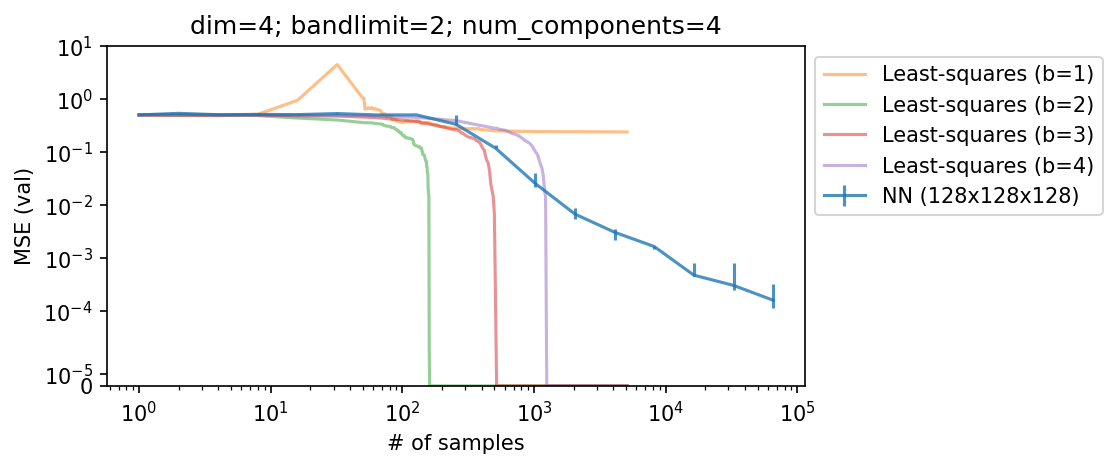

In [14]:
plt.figure(dpi=150, figsize=(6, 3))

plot_errorbar(
    xs=RUNS["n128"].ns,
    ys=RUNS["n128"].val_mses,
    label="NN (128x128x128)", alpha=0.8, zorder=10
)

#plt.plot(RUNS["n128"].ns, , label="NN (128x128x128)", alpha=0.8, zorder=10)

#plt.plot(RUNS["n128"].ns, RUNS["n128"].val_mses.max(axis=-1))
#plt.plot(RUNS["n128"].ns, RUNS["n128"].train_mses.min(axis=-1))
#plt.plot(RUNS["n128"].ns, RUNS["n128"].train_mses.max(axis=-1))

plt.plot(LS_DATA["b1"].ns, LS_DATA["b1"].val_mses.min(axis=-1), label="Least-squares (b=1)", alpha=0.5)
plt.plot(LS_DATA["b2"].ns, LS_DATA["b2"].val_mses.min(axis=-1), label="Least-squares (b=2)", alpha=0.5)
plt.plot(LS_DATA["b3"].ns, LS_DATA["b3"].val_mses.min(axis=-1), label="Least-squares (b=3)", alpha=0.5)
plt.plot(LS_DATA["b4"].ns, LS_DATA["b4"].val_mses.min(axis=-1), label="Least-squares (b=4)", alpha=0.5)

plt.xscale("log")
plt.yscale('symlog', linthresh=5e-5);
plt.ylim(0, 10)

plt.title("dim=4; bandlimit=2; num_components=4")
plt.xlabel("# of samples")
plt.ylabel("MSE (val)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1));